This notebook fits the iwiw ABM with the method of Xiao et al. to the data.

In [9]:
import pandas as pd
import numpy as np
import json
from itertools import product
from time import time

from SI import SI, DE_fit

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 18


from scipy.optimize import curve_fit

First, we run ABMs with different $(p,q)$ pairs. We create 10 simulations for each parameter settings, and then average the results.

In [ ]:
pvec = np.linspace(0.25,2,8)*1e-4 # all p values
qvec = np.linspace(0.08,0.20,7) # all q values
pairs = product(pvec,qvec) # all possible parameter pairs

output = open('parameter_sweep_results.json','w') # storing simulation results

for i,(p,q) in enumerate(pairs):
    print(i,end=", ")
    tic=time()
    conf = {"num_runs":10,"p":p,"q":q}
    sim = SI(**conf)
    res = sim.average_batch(sim.run_batch())
    res.update({"run_id":i})
    output.write(json.dumps(res))
    output.write('\n')
    toc=time()
    print("Time elapsed: %.2f s." % (toc-tic))
        
output.close()

Calculating the corresponding DE $(P,Q)$ pairs.

In [3]:
param_sweep_data = []

with open('parameter_sweep_results.json') as f:
    for line in f:
        simulation_results = json.loads(line.strip('\n'))
        de_fit = DE_fit(simulation_results)
        (P,Q),param_cov = de_fit.fit()
        param_sweep_data.append({
            "P":P,
            "P_err":np.sqrt(param_cov[0,0]),
            "Q":Q,
            "Q_err":np.sqrt(param_cov[1,1]),
            "p":simulation_results["p"],
            "q":simulation_results["q"]
        })

param_sweep_data = pd.DataFrame.from_dict(param_sweep_data)
param_sweep_data.head()

,P,P_err,Q,Q_err,p,q
0,0.000034,1.870597e-07,0.068450,0.000060,0.000025,0.08
1,0.000032,3.150452e-07,0.086273,0.000121,0.000025,0.10
2,0.000031,3.856295e-07,0.103465,0.000181,0.000025,0.12
3,0.000033,4.873593e-07,0.120492,0.000247,0.000025,0.14
4,0.000034,5.741737e-07,0.136753,0.000314,0.000025,0.16


Fitting the linear relationship between the Bass DE parameters $(P,Q)$ and the ABM parameters $(p,q)$:

$$\left(\begin{array}{c}p\\q\end{array}\right) = \underline{\underline{C}}\left(\begin{array}{c}P\\Q\end{array}\right)+\underline{\varepsilon}$$

In [4]:
def param_transform1(X,p1,p2,p5):
    # fitting the first line
    C = (p1,p2)
    eps = p5
    return C[0]*X[0]+C[1]*X[1]+eps
            
def param_transform2(X,p3,p4,p6):
    # fitting the second line
    C = (p3,p4)
    eps = p6
    return C[0]*X[0]+C[1]*X[1]+eps

In [5]:
(p1,p2,p5), pcov1 = curve_fit(
    param_transform1,
    param_sweep_data.values[:,[0,2]].T,
    param_sweep_data.values[:,4]
)

(p3,p4,p6), pcov2 = curve_fit(
    param_transform1,
    param_sweep_data.values[:,[0,2]].T,
    param_sweep_data.values[:,5]
)

# fit parameters
C = np.matrix([[p1,p2],[p3,p4]])
eps = np.matrix([p5,p6]).T

# whole transformation
def param_transform(X):
    return C*X+eps

In [6]:
param_sweep_data["p_est"] = param_sweep_data.apply(lambda row:
                        np.array((param_transform(np.matrix([row["P"],row["Q"]]).T).T))[0][0]
                       ,axis=1)

param_sweep_data["q_est"] = param_sweep_data.apply(lambda row:
                        np.array((param_transform(np.matrix([row["P"],row["Q"]]).T).T))[0][1]
                       ,axis=1)

Checking the relationship of the simulation input parameters and the DE estimated $p_{est}$ and $q_{est}$.

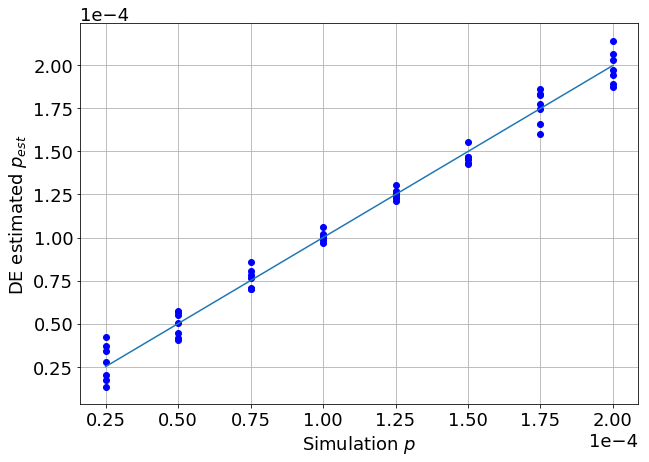

In [16]:
plt.figure(figsize=(10,7))
plt.plot(param_sweep_data["p"],param_sweep_data["p_est"],'bo')
plt.plot(param_sweep_data["p"],param_sweep_data["p"])
plt.xlabel("Simulation $p$")
plt.ylabel("DE estimated $p_{est}$")
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.grid()
plt.show()

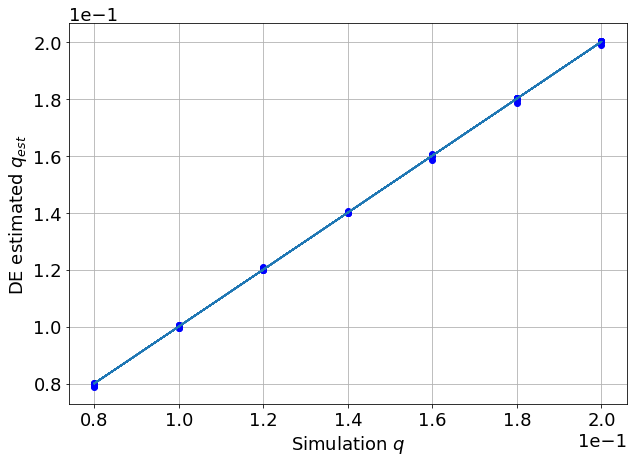

In [17]:
plt.figure(figsize=(10,7))
plt.plot(param_sweep_data["q"],param_sweep_data["q_est"],'bo')
plt.plot(param_sweep_data["q"],param_sweep_data["q"])
plt.xlabel("Simulation $q$")
plt.ylabel("DE estimated $q_{est}$")
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.grid()
plt.show()

Calculating DE fit to the data and converting $(\hat{P},\hat{Q})$ to $(p_0,q_0)$, then plotting it. Input $p$ and input $q$ serve as starting points for best nonlinear fit search.

In [18]:
original_timeline = np.concatenate([pd.read_csv('./vertices_fs.csv').groupby("month").count()["id"].values,[0,0]])
original_data = {
    "avg_timeline": original_timeline,
    "p": 1e-4,
    "q": 0.1,
    "stop": 129,
    "num_nodes": len(pd.read_csv('./vertices_fs.csv').index),
    "high": None,
    "low": None
}

In [19]:
de_fit_data = DE_fit(original_data)
(PH,QH),dp_cov = de_fit_data.fit() # P_hat, Q_hat

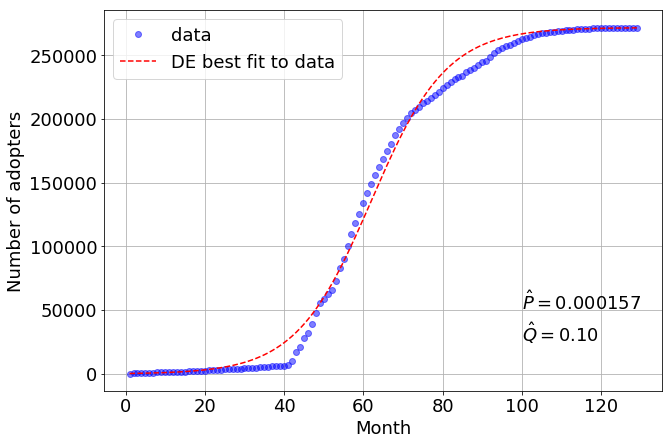

In [22]:
plt.figure(figsize=(10,7))
plt.plot(de_fit.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit.t,de_fit.bass_solution(de_fit.t,PH,QH),'r--',label='DE best fit to data')
plt.annotate(r'$\hat{P}=%.6f$' % PH,(100,50000))
plt.annotate(r'$\hat{Q}=%.2f$' % QH,(100,25000))
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.grid()
plt.show()

In [23]:
p0,q0 = map(float,param_transform(np.matrix([PH,QH]).T))

ABM parameters corresponding to best fitting DE.

In [24]:
print("p0",p0,"q0",q0)

p0 0.00019396000397236234 q0 0.11907040888413596


Setting up parameter search grid, and optimizing for least deviating parameter set.

In [25]:
# grid spacing
dp = 0.00001
dq = 0.01

# search matrix
A = list(product([-1,0,1],[-1,0,1]))

# first timestep
new_candidates = np.array(A)
already_visited = np.array([])
sse_errors = np.array([])

counter=0
while len(new_candidates)>0:
    # list to store all errors calculated
    new_errors = []
    for coord in new_candidates:
        # grid p,q at position coord
        p = p0 + coord[0] * dp
        q = q0 + coord[1] * dq
        # give p and q to config
        conf = {"num_runs":10,"p":p,"q":q}
        sim = SI(**conf)
        # run simulation, calculate SSE
        err = np.sum((np.cumsum(np.array(sim.average_batch(sim.run_batch())["avg_timeline"]))-np.cumsum(original_timeline))**2)
        new_errors.append(err)
    new_errors = np.array(new_errors)
    
    # append errors and visited positions to lists
    if len(already_visited)>0:
        already_visited = np.concatenate([already_visited,new_candidates])
    else:
        already_visited = new_candidates
    if len(sse_errors)>0:
        sse_errors = np.concatenate([sse_errors,new_errors])
    else:
        sse_errors = new_errors
     
    # extend the border of the search grid
    new_candidates = []
    # get the two minimum SSE positions
    proposal_centers = np.argsort(sse_errors)[0:2]

    # place search matrix on top of minimum SSE positions
    for c in already_visited[proposal_centers]:
        for elem in A:
            # propose new p and q search positions on grid (these are in grid coordinates...)
            pc,qc = elem[0]+c[0],elem[1]+c[1]
            if (pc,qc) not in set([(p,q) for p,q in list(already_visited)]):
                new_candidates.append(np.array((pc,qc)))
    new_candidates = np.array(new_candidates)
    counter+=1
    print("End of round",counter," num new candidates was",len(new_candidates))

End of round 1  num new candidates was 3
End of round 2  num new candidates was 0


We got back the best fit, if we optimize with smaller steps, maybe there is a slight change in the third valuable digit, but it does not really matter.

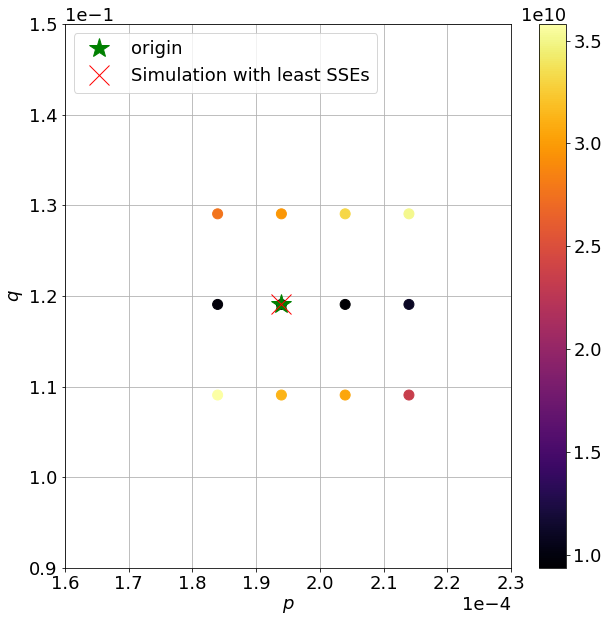

In [32]:
plt.figure(figsize=(10,10))

plt.plot(p0,q0,'g*',markersize=20,label="origin")
plt.plot(p0+dp*already_visited[np.argmin(sse_errors),0],q0+dq*already_visited[np.argmin(sse_errors),1],'rx',markersize=20,label="Simulation with least SSEs")
plt.scatter(p0+dp*already_visited[:,0],q0+dq*already_visited[:,1],s=100,c=sse_errors,cmap='inferno')

plt.grid()
plt.xlabel("$p$")
plt.ylabel("$q$")
plt.xlim(1.6e-4,2.3e-4)
plt.ylim(0.09,0.15)
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.legend(loc="upper left")
plt.colorbar()
plt.show()

Final parameter values.

In [34]:
p_end = p0+dp * already_visited[np.argmin(sse_errors)][0]
q_end = q0+dq * already_visited[np.argmin(sse_errors)][1]

In [35]:
print(r"$p_{opt}$",p_end,r"$q_{opt}$",q_end)

$p_{opt}$ 0.00019396000397236234 $q_{opt}$ 0.11907040888413596


In [36]:
conf = {"num_runs":10,"p":p_end,"q":q_end}
sim = SI(**conf)
res = sim.average_batch(sim.run_batch())

In [37]:
conf = {"num_runs":10,"p":p0,"q":q0}
sim = SI(**conf)
res2 = sim.average_batch(sim.run_batch())

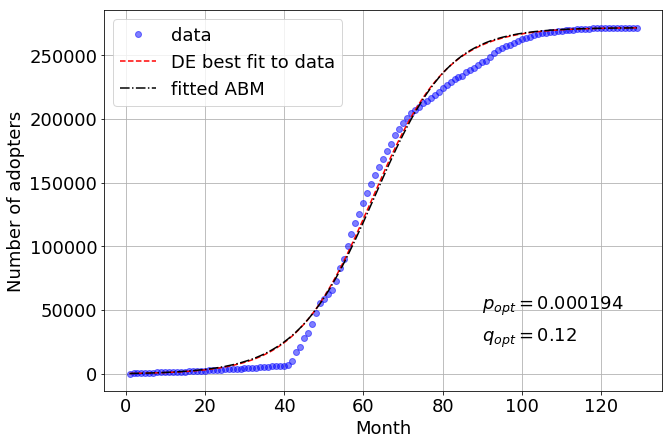

In [40]:
plt.figure(figsize=(10,7))
plt.plot(de_fit.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit.t,de_fit.bass_solution(de_fit.t,PH,QH),'r--',label='DE best fit to data')
plt.plot(de_fit.t,np.cumsum(res['avg_timeline']),'-.',color='black',label="fitted ABM")

plt.annotate(r'$p_{opt}=%.6f$' % p_end,(90,50000))
plt.annotate(r'$q_{opt}=%.2f$' % q_end,(90,25000))
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.grid()
plt.show()

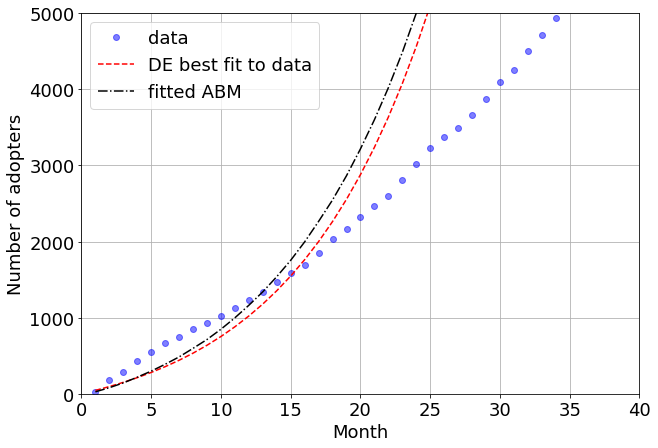

In [42]:
plt.figure(figsize=(10,7))
plt.plot(de_fit.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit.t,de_fit.bass_solution(de_fit.t,PH,QH),'r--',label='DE best fit to data')
plt.plot(de_fit.t,np.cumsum(res['avg_timeline']),'-.',color='black',label="fitted ABM")
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.legend()
plt.grid()
plt.xlim(0,40)
plt.ylim(0,5e3)
plt.show()